# MCMC fit with Chase+2017 Mini ($\lambda_0, \sigma$ fixed)

In [19]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

import corner

from scipy.interpolate import interp1d

from bing.models import anw as bing_anw
from ocpy.utils import plotting

import anly_utils
import fit_anw

In [2]:
%matplotlib ipympl

# defs

In [3]:
def show_fit(model, model_anw, p0, fit_lbl, abs_noise:float):
    fig = plt.figure(figsize=(9,5))
    ax = plt.gca()
    ax.plot(model.wave, model.eval_anw(p0).flatten(), 'b-', label=fit_lbl)
    ax.plot(model.wave, model_anw, 'k-', label='True')
    ax.legend(fontsize=15.)
    ax.errorbar(model.wave, model_anw, yerr=abs_noise, fmt='o', color='k')
    # 
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel(r'$a_{\rm nw} \; \rm [m^{-1}]$')
    plotting.set_fontsize(ax, 17)
    plt.show()

# Parameters

In [14]:
idx=170 
nsteps=20000 
max_wave=600.
abs_noise=0.002 
min_wave=400.

# Init model

In [5]:
init_from_chi2='fitanw_170_LM_Chase2017Mini.npz'
d = np.load(init_from_chi2)

In [6]:
model = bing_anw.init_model('Chase2017Mini', d['wave'])
model_anw = d['obs_anw']

# Show the initial guess

In [7]:
p0 = d['ans']

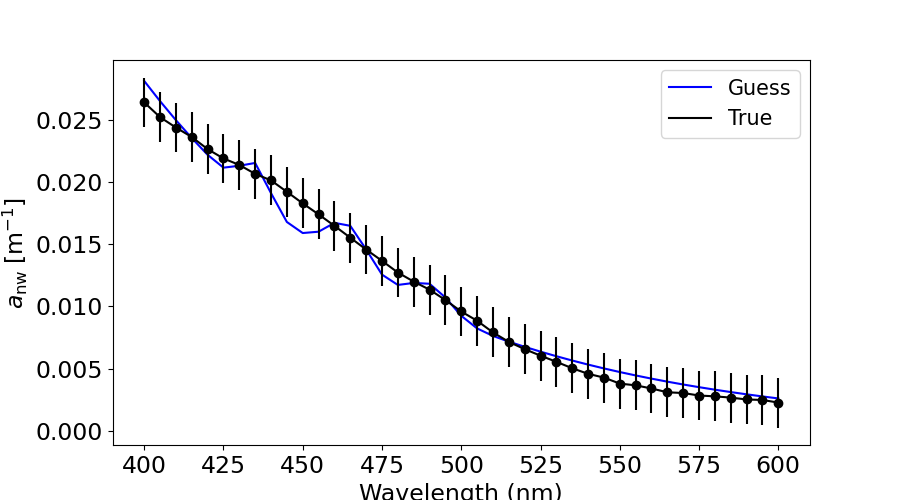

In [8]:
show_fit(model, model_anw, p0, 'Guess', abs_noise)

# Fit

In [13]:
reload(fit_anw)
chains = fit_anw.fit('Chase2017Mini', idx, None,
         show=False, use_chisq=False, nsteps=nsteps, max_wave=max_wave,
                    abs_noise=abs_noise, chk_guess=False, min_wave=min_wave, 
                    init_from_chi2='fitanw_170_LM_Chase2017Mini.npz')

idx=170
Running burn-in


  0%|                                                 | 0/1000 [00:00<?, ?it/s]/home/xavier/miniconda3/envs/os_11/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████| 1000/1000 [00:02<00:00, 383.10it/s]


Running full model


100%|███████████████████████████████████| 20000/20000 [00:46<00:00, 433.37it/s]


# Examine the fit

## Analyze

In [15]:
burn=7000 
thin=1
chains = chains[burn::thin, :, :].reshape(-1, chains.shape[-1])
anw = model.eval_anw(chains)

# Calculate the mean and standard deviation
a_mean = np.median(anw, axis=0)
a_5, a_95 = np.percentile(anw, [5, 95], axis=0)
errs = [a_5, a_95]

## Show 

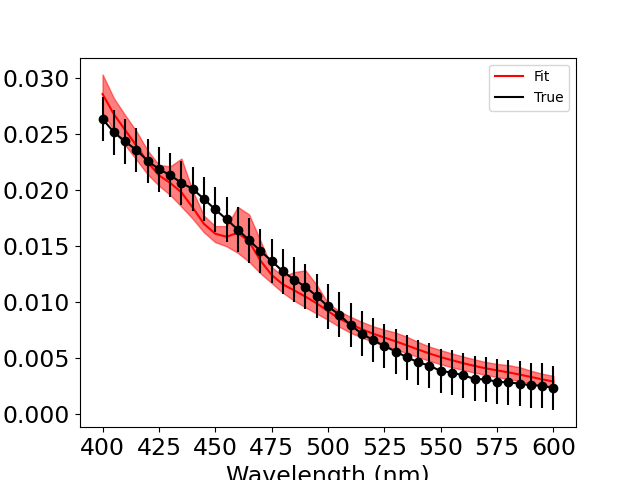

In [18]:
fig = plt.figure()
ax = plt.gca()
ax.plot(model.wave, a_mean, 'r-', label='Fit')
ax.fill_between(model.wave, errs[0], errs[1], color='r', alpha=0.5)
ax.plot(model.wave, model_anw, 'k-', label='True')
ax.legend()
ax.errorbar(model.wave, model_anw, yerr=abs_noise, fmt='o', color='k')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$a_{\rm nw} \; \rm [m^{-1}]$')
plotting.set_fontsize(ax, 17)
plt.show()

# Errors

## CDOM, NAP

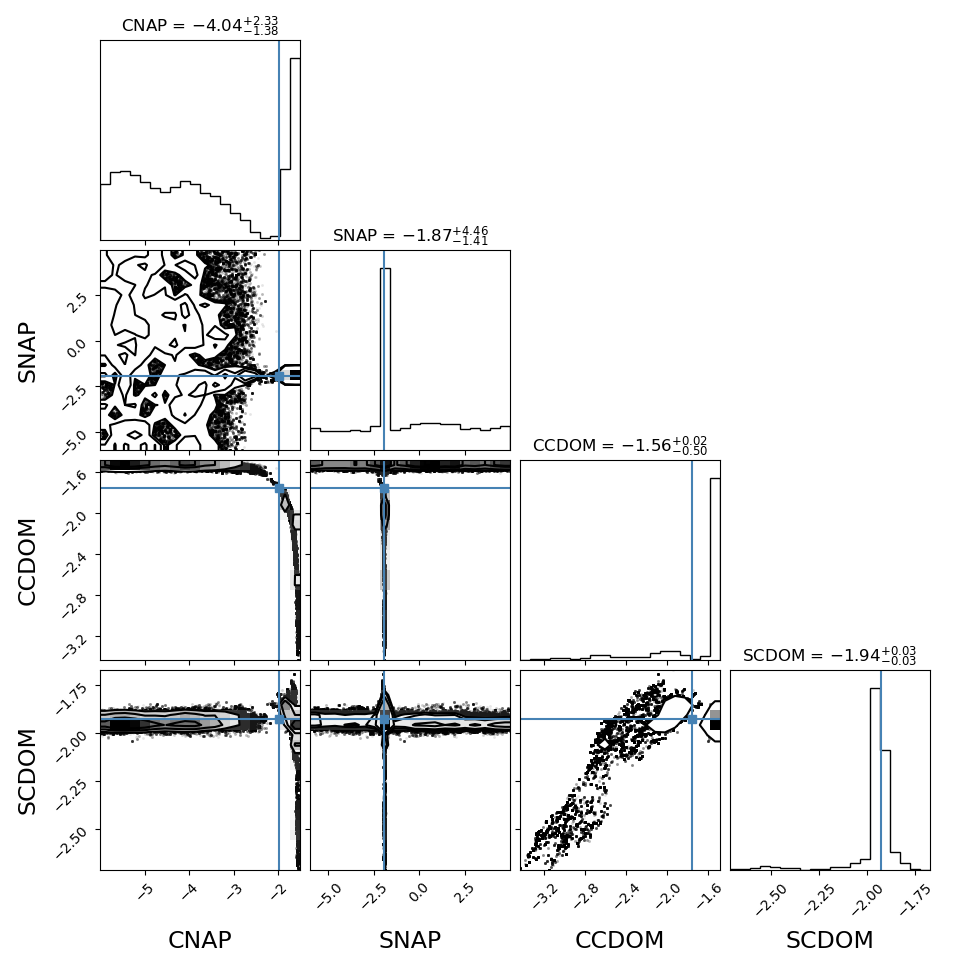

In [22]:
fig = corner.corner(
        chains[:,:4], labels=model.pnames[0:4],
        label_kwargs={'fontsize':17},
        color='k',
        #axes_scale='log',
        truths=p0[0:4],
        show_titles=True,
        title_kwargs={"fontsize": 12},
        )

## $a_{\rm ph}$

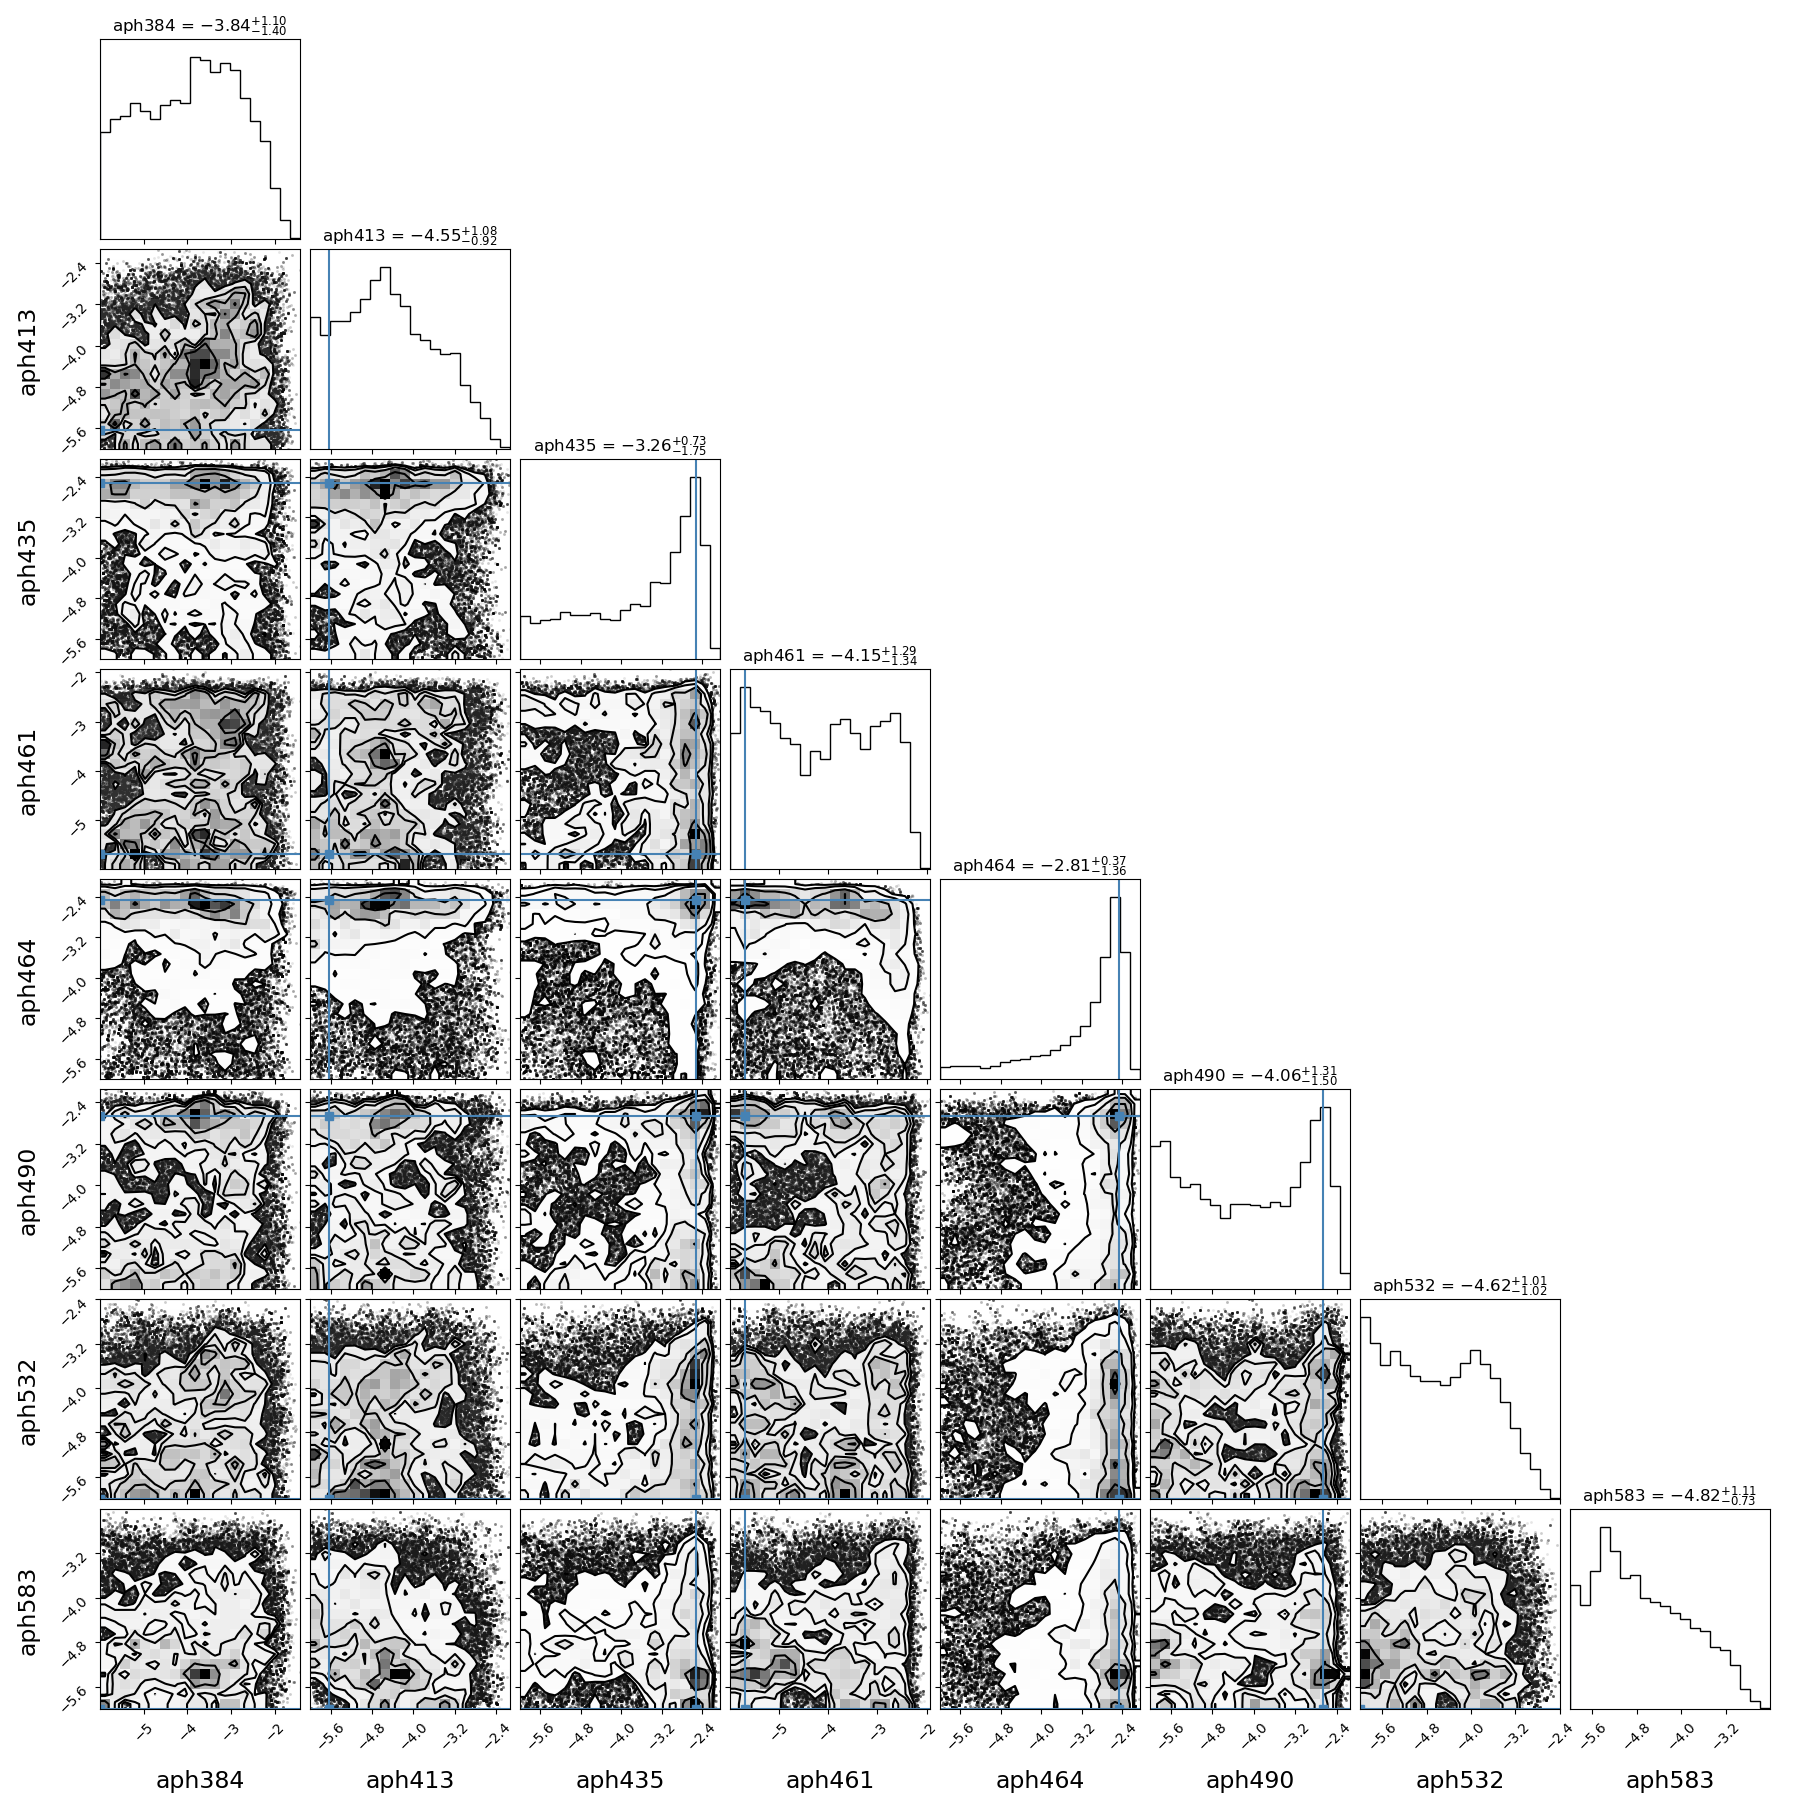

In [23]:
fig = corner.corner(
        chains[:,4:], labels=model.pnames[4:],
        label_kwargs={'fontsize':17},
        color='k',
        #axes_scale='log',
        truths=p0[4:],
        show_titles=True,
        title_kwargs={"fontsize": 12},
        )